# 1083 Albumin Initial ML

### By: Ian Weimer

## Imports

In [21]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
import math
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import cross_val_score
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
import warnings
from sklearn.compose import make_column_transformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import balanced_accuracy_score
import graphviz
import pydotplus
from imblearn.over_sampling import SMOTE, SMOTENC
pd.set_option('display.max_columns', None)

## Load Albumin Data From Pre-processing and Exploratory Analysis

In [22]:
df = pd.read_csv('C:/Users/Iweimer/Desktop/BB_Git/1083-albumin-data-exploration/ML/K72_Cohort/Tables/K72_HF_MATCHED_alb_24hrs.csv')

In [23]:
# drop insignificant vars

#df.drop(columns = ['bed_size', 'Cirrhosis', 'tenant'], inplace=True)

In [24]:
df.head()

personid                           encounterid  \
0  01013827-c0f0-42be-bc96-1ac714b7aaeb  7859a028-911e-452c-ad3f-c04f85f4a9c7   
1  14e14f39-6c68-4356-be3e-f62f9d6b65c2  af7e9a58-0837-49e0-86b2-e6781ea942f4   
2  2b67cff8-4f3a-4aa0-8fa0-1d342b88e516  9fd9125a-e53c-47ef-ad19-8a72d171897f   
3  3d335201-ebbc-47ec-881e-5e9eb6d6c681  7e925b39-2be4-4bf1-91d2-1dc475764426   
4  6c4ab780-b870-43d3-a9ec-253f457d6dc6  f2a08cf1-ff10-4ca4-863f-663e0b3d12e7   

    age  sex  ICU  bl_albumin_value  hgb_bl  beta_blocker  Cirrhosis  CCI  \
0  68.0    1    0               2.8    11.5             0          1    3   
1  37.0    0    1               2.7    15.5             0          0    2   
2  76.0    0    1               1.8    10.0             0          0    5   
3  30.0    1    1               1.8    14.4             0          1    3   
4  44.0    1    0               1.9     8.1             0          1    7   

   qSOFA    MELD  SEWS  ACLF  albumin_24hrs  albumin   LOS_days  \
0      0  23.508     0     0              1        1   3.039583   
1      2  22.640     3     1              1        1   3.818056   
2      1  16.000     2     1              1        1  12.167361   
3      0  33.848     2     2              1        1   7.840972   
4      2  37.990     1     1              1        1  12.403472   

   90_day_mortality  90_day_readmission  hospital_free_days  
0                 1                 0.0                   0  
1                 1                 0.0                   0  
2                 0                 0.0                  33  
3                 0                 1.0                   7  
4                 1                 0.0                   0

In [25]:
df.shape

(6810, 20)

## Select Only Patients Who Lived (Removing Patients in 0 Class Who Died)

In [26]:
df = df.loc[df['90_day_mortality'] == 0]

In [27]:
df.shape

(3530, 20)

## Look at outcomes distributions between patients who did and didn't receive albumin within 24 hrs

In [28]:
ra_90d_a24 = df[df['albumin_24hrs'] == 1]['90_day_readmission'].value_counts()
print(ra_90d_a24)

0.0    996
1.0    687
Name: 90_day_readmission, dtype: int64


In [29]:
def binary_pct(var):
    pct = (var[1]/(var[1]+var[0])) * 100
    return pct

binary_pct(ra_90d_a24)

40.819964349376114

In [30]:
ra_90d = df[df['albumin_24hrs'] == 0]['90_day_readmission'].value_counts()
print(ra_90d)

0.0    1044
1.0     803
Name: 90_day_readmission, dtype: int64


In [31]:
binary_pct(ra_90d)

43.47590687601516

In [32]:
df.drop(columns=['encounterid', 'personid', 'albumin'], inplace=True)

In [33]:
df.drop(columns=['90_day_mortality', 'LOS_days', 'hospital_free_days'], inplace=True)

In [34]:
# remove variables

# df.drop(columns=['mass_transfusion', 'anemia_status', 'qSOFA', 'hemorrhagic', 'bl_albumin_value', 'SAPS'], inplace=True)
# df.drop(columns=['qSOFA', 'bl_albumin_value', 'SAPS'], inplace=True)

In [35]:
df.describe()

age          sex          ICU  bl_albumin_value       hgb_bl  \
count  3530.000000  3530.000000  3530.000000       3530.000000  3530.000000   
mean     56.816997     0.587252     0.238810          2.253830    11.043654   
std      14.402207     0.492398     0.426417          0.452103     2.681684   
min      11.000000     0.000000     0.000000          0.800000     3.500000   
25%      48.000000     0.000000     0.000000          1.900000     9.200000   
50%      58.000000     1.000000     0.000000          2.300000    11.000000   
75%      67.000000     1.000000     0.000000          2.600000    12.800000   
max      89.000000     1.000000     1.000000          3.800000    19.900000   

       beta_blocker    Cirrhosis          CCI        qSOFA         MELD  \
count   3530.000000  3530.000000  3530.000000  3530.000000  3530.000000   
mean       0.296884     0.724646     4.487252     0.924363    24.310274   
std        0.456950     0.446756     2.700604     0.868974     8.218682   
min        0.000000     0.000000     0.000000     0.000000     6.000000   
25%        0.000000     0.000000     3.000000     0.000000    18.346000   
50%        0.000000     1.000000     4.000000     1.000000    24.452000   
75%        1.000000     1.000000     6.000000     1.000000    30.000000   
max        1.000000     1.000000    17.000000     3.000000    40.000000   

              SEWS         ACLF  albumin_24hrs  90_day_readmission  
count  3530.000000  3530.000000    3530.000000         3530.000000  
mean      1.809065     1.318697       0.476771            0.422096  
std       2.139993     1.008109       0.499531            0.493964  
min       0.000000     0.000000       0.000000            0.000000  
25%       0.000000     1.000000       0.000000            0.000000  
50%       1.000000     1.000000       0.000000            0.000000  
75%       3.000000     2.000000       1.000000            1.000000  
max      16.000000     5.000000       1.000000            1.000000

In [36]:
#df = df[['CCI', 'unknown_albumin_type', 'albumin_24hrs', '25_percent_albumin', 'LOS_days']]

## Modeling

In [37]:
# establish target feature, LOS_days, as y feature
y = df['90_day_readmission']
# drop target feature from features dataframe
X = df.drop(columns = ['90_day_readmission'], axis = 1)
# save dataframe column titles to list for reassigning after min max scale 
cols = X.columns

In [38]:
cols

Index(['age', 'sex', 'ICU', 'bl_albumin_value', 'hgb_bl', 'beta_blocker',
       'Cirrhosis', 'CCI', 'qSOFA', 'MELD', 'SEWS', 'ACLF', 'albumin_24hrs'],
      dtype='object')

## Standardize Data

In [39]:
#cols = X.columns

#instantiate min-max scaling object
#mm = MinMaxScaler()
# fit and transform feature dataframe
#X = pd.DataFrame(mm.fit_transform(X))
# reassign column names so new dataframe has corresponding names
#X.columns = cols

In [40]:
X.head()

age  sex  ICU  bl_albumin_value  hgb_bl  beta_blocker  Cirrhosis  CCI  \
2  76.0    0    1               1.8    10.0             0          0    5   
3  30.0    1    1               1.8    14.4             0          1    3   
5  66.0    0    0               1.5    14.6             0          0    0   
6  80.0    1    0               2.7    11.0             0          1    5   
7  56.0    1    0               2.9    11.5             0          1    4   

   qSOFA    MELD  SEWS  ACLF  albumin_24hrs  
2      1  16.000     2     1              1  
3      0  33.848     2     2              1  
5      2  19.148     4     1              1  
6      0  18.000     0     1              1  
7      2  11.000     3     0              1

## Train Test Split

In [41]:
sm = SMOTENC(random_state=42, categorical_features = [1, 2,  \
                                                     5, 6, 8, 10, 11, 12])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [42]:
#sm = SMOTEN(random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#X_train, y_train = sm.fit_resample(X_train, y_train)

In [43]:
y_train.value_counts()

1.0    1635
0.0    1635
Name: 90_day_readmission, dtype: int64

In [44]:
# train test split from target feature series and the predicting feature dataframe (set test size to 20% of data)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 33)

## Multinomial Logistic Regression

In [45]:
# instantiate a Logistic Regression model without an intercept, 'liblinear' solver method
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# fit the model to X and y training sets
logreg.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(multi_class='multinomial')

Feature: age Score: -0.00415
Feature: sex Score: 0.07277
Feature: ICU Score: -0.20555
Feature: bl_albumin_value Score: 0.12504
Feature: hgb_bl Score: -0.01360
Feature: beta_blocker Score: -0.02333
Feature: Cirrhosis Score: 0.26254
Feature: CCI Score: -0.00429
Feature: qSOFA Score: -0.05301
Feature: MELD Score: -0.00934
Feature: SEWS Score: -0.04051
Feature: ACLF Score: -0.05663
Feature: albumin_24hrs Score: -0.00998


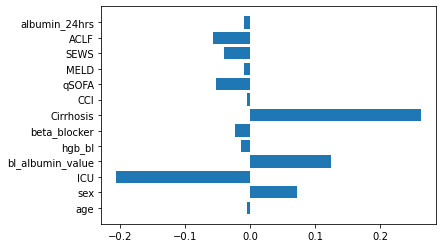

In [46]:
# general quick feature importance
# get coefficients for importance
# coefficients represent the log odds that an observation is in the
# target class, given the values of its X variables

importance = logreg.coef_[0]
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

                  Importance
Cirrhosis           1.300233
bl_albumin_value    1.133195
sex                 1.075480
age                 0.995861
CCI                 0.995716
MELD                0.990705
albumin_24hrs       0.990069
hgb_bl              0.986489
beta_blocker        0.976935
SEWS                0.960301
qSOFA               0.948372
ACLF                0.944946
ICU                 0.814203


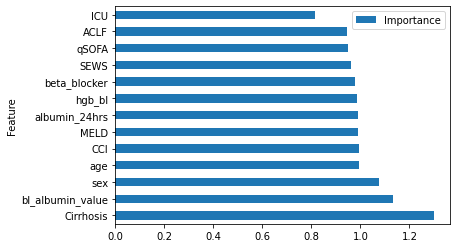

In [47]:
# convert log odds into regular odds with exponentiation
# np.exp()
# and list values, visualize in bar plot

odds = np.exp(logreg.coef_[0])
feature_importance = \
            pd.DataFrame(odds, 
             X.columns, 
             columns=['Importance'])\
            .sort_values(by='Importance', ascending=False)
        
ax = feature_importance.plot.barh(xlabel='Feature', ylabel='Importance')
print(feature_importance)
plt.show()

In [48]:
# Generate model prediction data for train and test sets
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

In [49]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[ 906  729]
 [ 521 1114]]


In [50]:
# model metrics for training set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

         0.0       0.63      0.55      0.59      1635
         1.0       0.60      0.68      0.64      1635

    accuracy                           0.62      3270
   macro avg       0.62      0.62      0.62      3270
weighted avg       0.62      0.62      0.62      3270



In [51]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[223 182]
 [114 187]]


In [52]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

         0.0       0.66      0.55      0.60       405
         1.0       0.51      0.62      0.56       301

    accuracy                           0.58       706
   macro avg       0.58      0.59      0.58       706
weighted avg       0.60      0.58      0.58       706



## 5: Decision Tree 

In [54]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)

Feature: age Score: 0.08904
Feature: sex Score: 0.00000
Feature: ICU Score: 0.13065
Feature: bl_albumin_value Score: 0.00000
Feature: hgb_bl Score: 0.06064
Feature: beta_blocker Score: 0.00000
Feature: Cirrhosis Score: 0.26592
Feature: CCI Score: 0.02215
Feature: qSOFA Score: 0.07046
Feature: MELD Score: 0.14634
Feature: SEWS Score: 0.20053
Feature: ACLF Score: 0.00000
Feature: albumin_24hrs Score: 0.01427


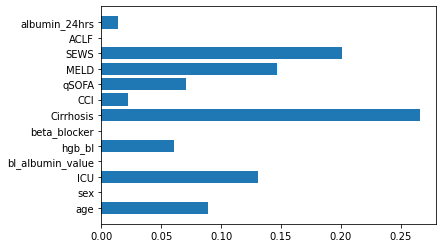

In [55]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [56]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [57]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[ 862  773]
 [ 439 1196]]


In [58]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

         0.0       0.66      0.53      0.59      1635
         1.0       0.61      0.73      0.66      1635

    accuracy                           0.63      3270
   macro avg       0.63      0.63      0.63      3270
weighted avg       0.63      0.63      0.63      3270



In [59]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[192 213]
 [105 196]]


In [60]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

         0.0       0.65      0.47      0.55       405
         1.0       0.48      0.65      0.55       301

    accuracy                           0.55       706
   macro avg       0.56      0.56      0.55       706
weighted avg       0.58      0.55      0.55       706



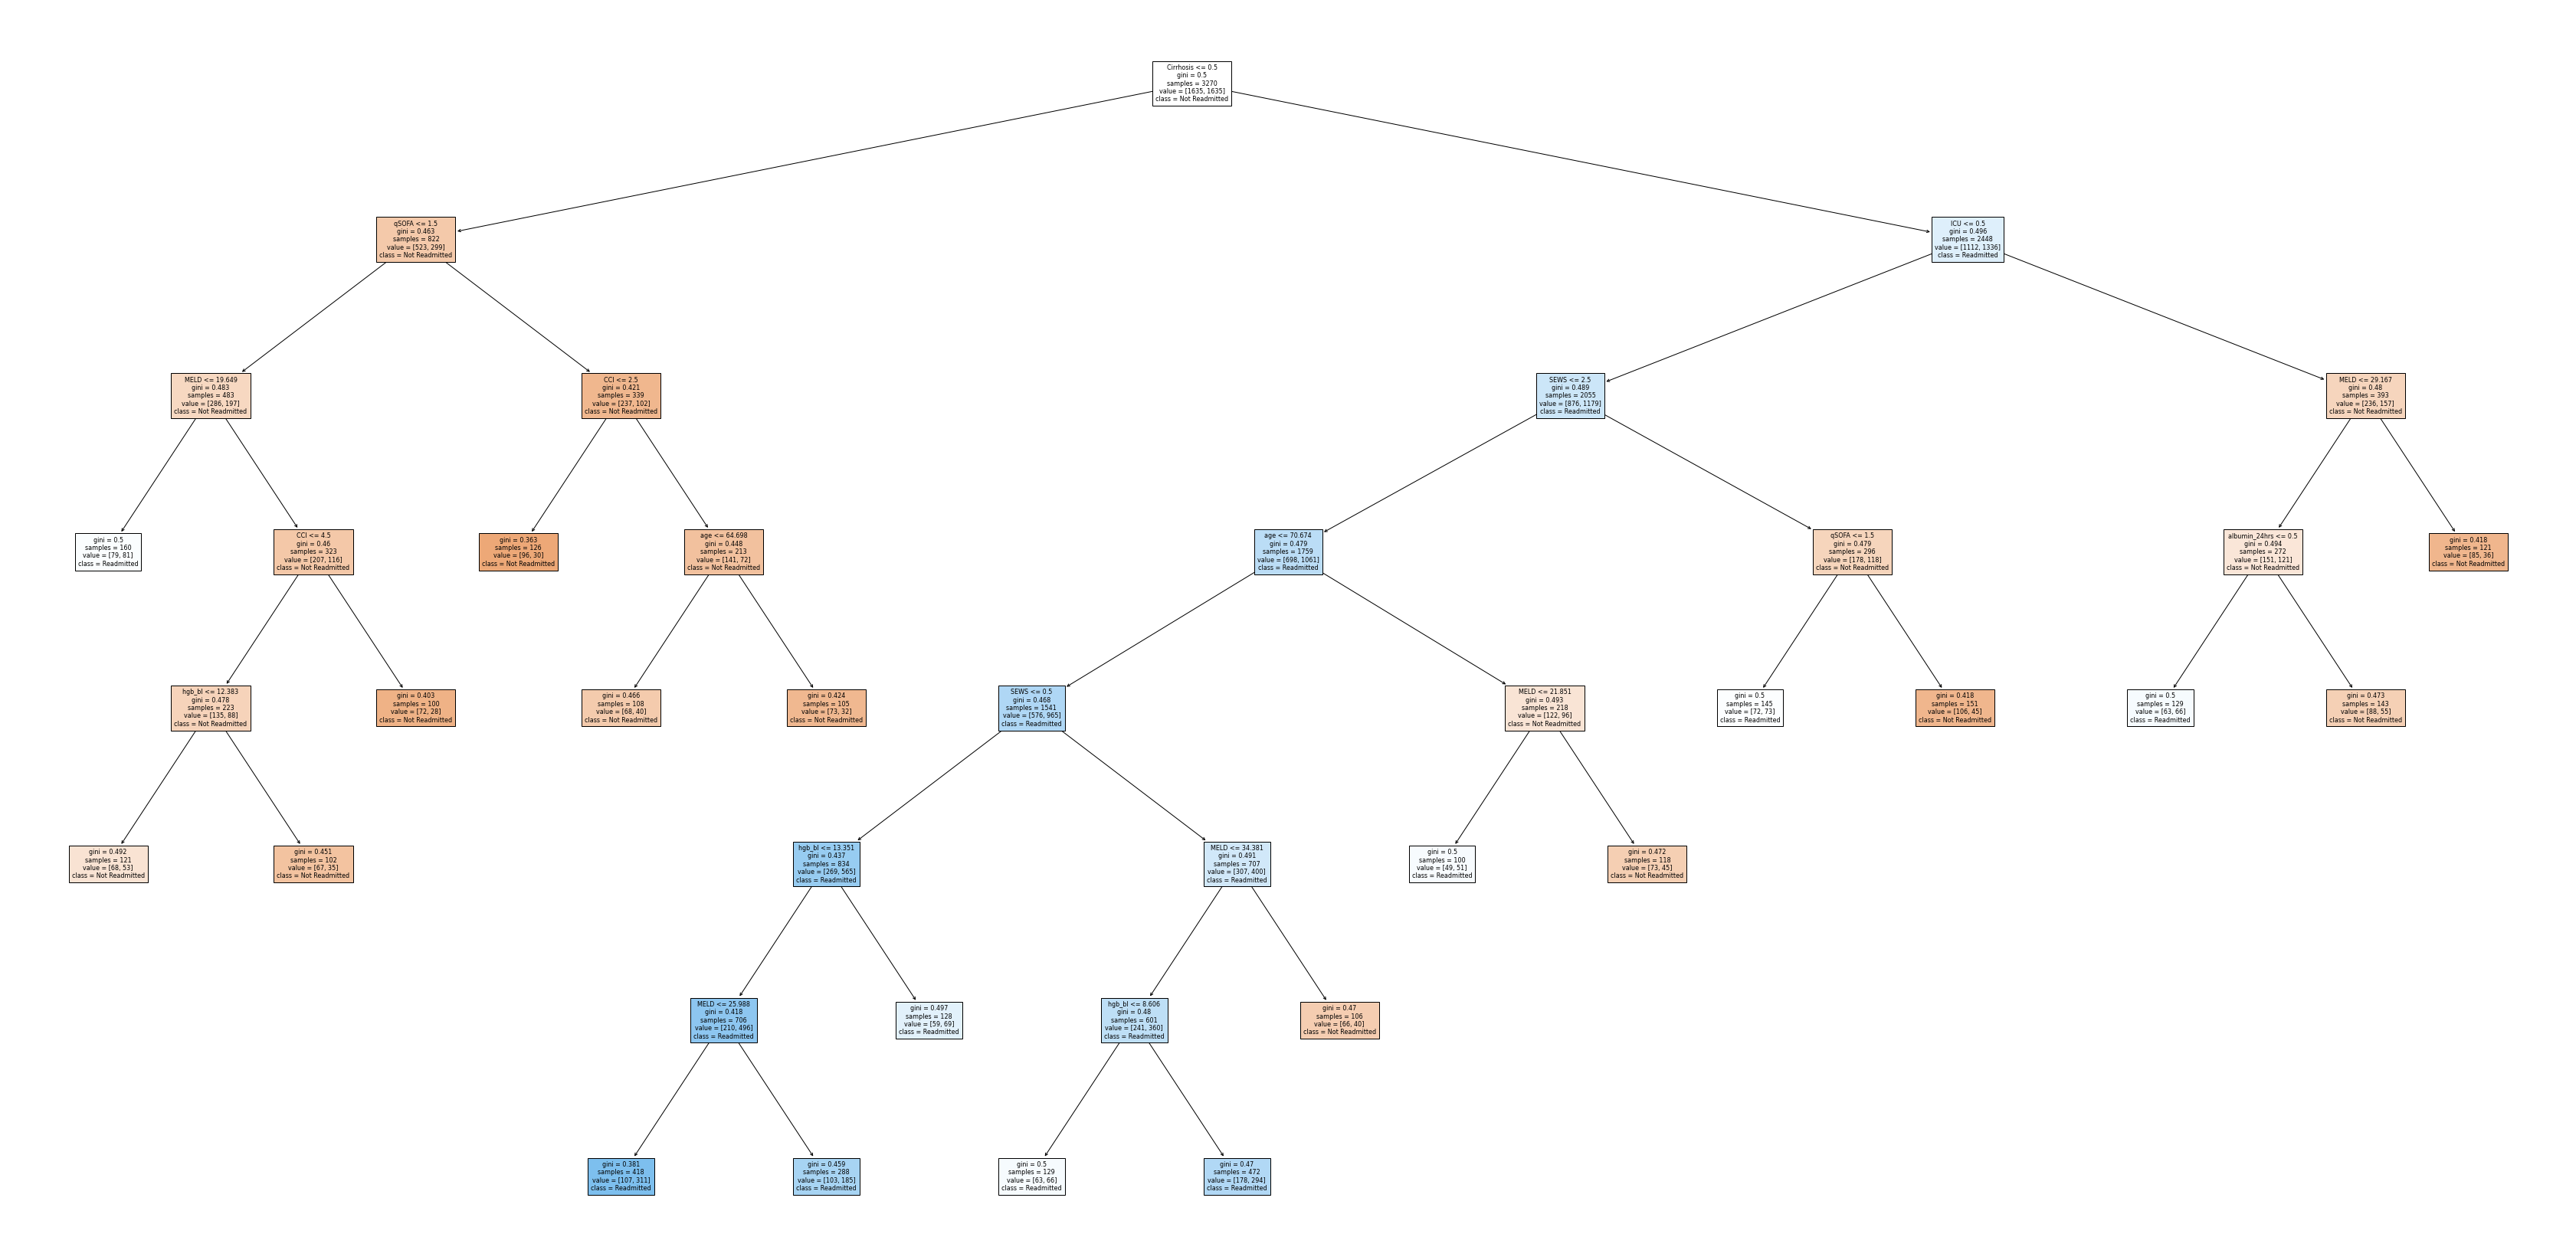

In [61]:
feature_names = X_train.columns.tolist()
class_names = ['Not Readmitted', 'Readmitted']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [62]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('90DRA_DT_D7_PSM_MATCHED.png')

True

## 6: Decision Tree 

In [342]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=8, min_samples_leaf=100)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=100)

Feature: ICU Score: 0.02855
Feature: mass_transfusion Score: 0.07814
Feature: total_transfusions Score: 0.00523
Feature: anemia_status Score: 0.23457
Feature: CCI Score: 0.03377
Feature: bl_albumin_value Score: 0.16639
Feature: qSOFA Score: 0.18940
Feature: Cirrhosis Score: 0.02734
Feature: beta_blocker Score: 0.02585
Feature: hemorrhagic Score: 0.05270
Feature: SAPS Score: 0.12075
Feature: albumin_24hrs Score: 0.03730


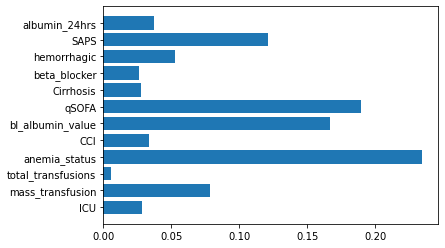

In [343]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [344]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [345]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[3432 2195]
 [2032 3595]]


In [346]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.63      0.61      0.62      5627
           1       0.62      0.64      0.63      5627

    accuracy                           0.62     11254
   macro avg       0.62      0.62      0.62     11254
weighted avg       0.62      0.62      0.62     11254



In [347]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[823 576]
 [347 332]]


In [348]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.70      0.59      0.64      1399
           1       0.37      0.49      0.42       679

    accuracy                           0.56      2078
   macro avg       0.53      0.54      0.53      2078
weighted avg       0.59      0.56      0.57      2078



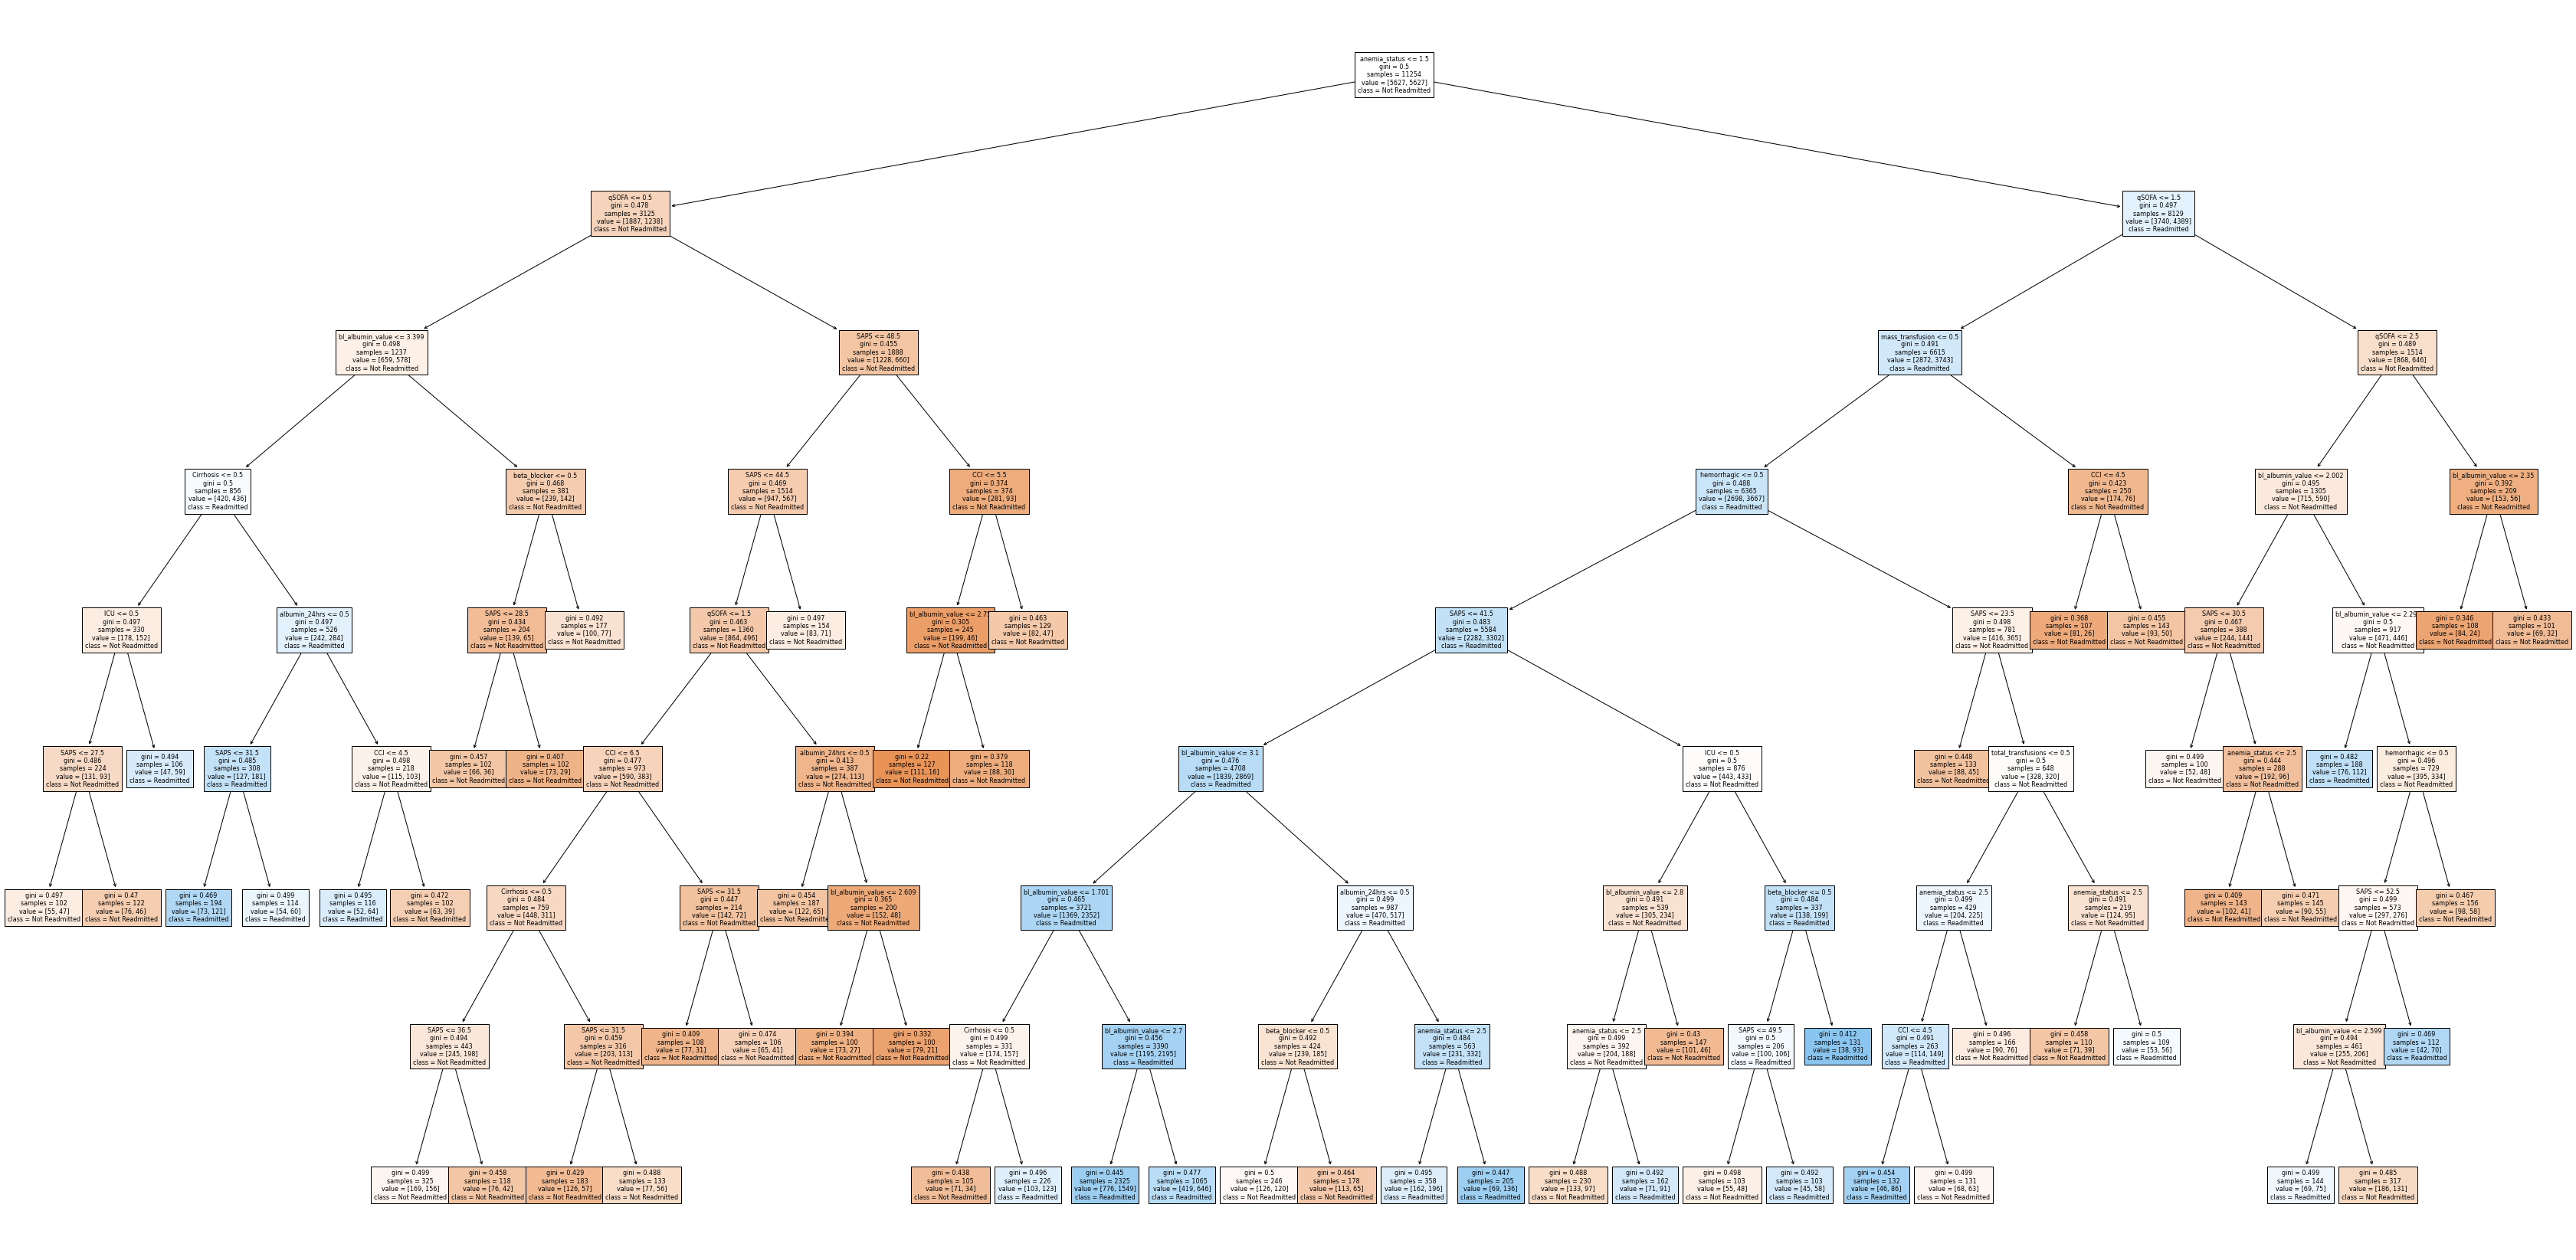

In [349]:
feature_names = X_train.columns.tolist()
class_names = ['Not Readmitted', 'Readmitted']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [351]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('90DRA_DT_D8_NCBL_MATCHED.png')

True

## Random Forest

In [79]:
rf = RandomForestClassifier(max_depth=8, min_samples_leaf=100)
# fit the model to X and y training sets
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=100)

In [80]:
# generate model prediction data for train and test sets
y_hat_train = rf.predict(X_train)
y_hat_test = rf.predict(X_test)

In [81]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[19668 14674]
 [14540 19802]]


In [82]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.57      0.57      0.57     34342
           1       0.57      0.58      0.58     34342

    accuracy                           0.57     68684
   macro avg       0.57      0.57      0.57     68684
weighted avg       0.57      0.57      0.57     68684



In [83]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[4861 3649]
 [1780 1932]]


In [84]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.73      0.57      0.64      8510
           1       0.35      0.52      0.42      3712

    accuracy                           0.56     12222
   macro avg       0.54      0.55      0.53     12222
weighted avg       0.61      0.56      0.57     12222



Feature: anemia_status Score: 0.12464
Feature: CCI Score: 0.40683
Feature: albumin_24hrs Score: 0.04143
Feature: qSOFA Score: 0.05016
Feature: SAPS Score: 0.37694


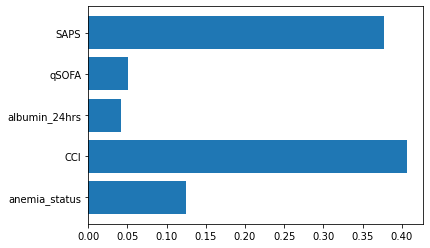

In [85]:
# get importance from decision tree model
importance = rf.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()